In [1]:
from transformers import BertTokenizer, TFBertModel
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import pandas as pd

import unicodedata
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import re

from sklearn import preprocessing

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [2]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(1)

In [3]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#model = TFBertModel.from_pretrained("bert-base-cased")
#text = "Replace me by any text you'd like."
#encoded_input = tokenizer(text, return_tensors='tf')
#output = model(encoded_input)

model_name="bert-base-uncased"

tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

max_length = 512

In [4]:
#uploaded = files.upload()
#data_df = pd.read_csv(io.BytesIO(uploaded['msds543_chatbotdata.csv']))
#varieties_df = pd.read_csv(io.BytesIO(uploaded['wine_list.csv']))
#blogOsVinhos = pd.read_excel("BlogOsVinhos.xlsx")

FILE_PATH = "../../master-thesis/data/"

data_df = pd.read_csv(f"{FILE_PATH}/msds543_chatbotdata.csv")
varieties_df = pd.read_csv(f"{FILE_PATH}/wine_list.csv")
blogOsVinhos = pd.read_excel(f"{FILE_PATH}/BlogOsVinhos.xlsx")
blogOsVinhos.rename(columns={"Name": "name", "Region": "region", "Producer": "brand"
                            }, inplace=True)

In [5]:
def strip_accents(STR):
    return ''.join(c for c in unicodedata.normalize('NFD', STR)
                   if unicodedata.category(c) != 'Mn')

def clean_doc(doc): 
    """
    Given a string doc,
    this function cleans the doc
    of . . .
    non-ascii chars
    punctuation
    anything other than lower case words
    non-alphabetic tokens
    stop words
    tokens shorter than length 3
    stem, lemma are also options
    returns the list of tokens.
    """
    doc = re.sub(r'[^\x00-\x7F]', '', str(doc)) # removes any remaining non-ascii chars
    
    tokens = doc.split(" ") # set the tone
    
    # punctuation situation
    sub_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [str(sub_punc.sub('', w)) for w in tokens]
    
    # alpha
    tokens = [word for word in tokens if word.isalpha()]
    
    # shorties
    tokens = [word for word in tokens if len(word) > 3]
    
    # capitalization
    tokens = [word.lower() for word in tokens]
    
    # stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    
    # lemma
    return tokens # tokens is a list

In [6]:
blogOsVinhos.head()

,name,region,Year,Color,Castes,AlcoholPercentage,brand,MinimunPrice,MaximumPrice,Judge,JudgeRating,Date,JudgeNotes,Label,Link
0,.Beb 2007,Regional Alentejo,2007,Rosé,"Cabernet Sauvignon, Syrah e Touriga Nacional",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço,15.5,Dezembro 2008,Cor vermelha brilhante e aromas iniciais domin...,Tem uma cor atraente e um aroma intenso a frut...,https://osvinhos.blogspot.pt/2010/03/1232-beb-...
1,.Beb 2009,Regional Alentejo,2009,Red,"Cabernet Sauvignon, Syrah, Alicante Bouschet e...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Susana Esteban,16.0,Novembro 2012,"Cor avermelhada e nariz muito aromático, onde ...",A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2013/08/2803-beb-...
2,.Beb 2010,Regional Alentejo,2010,Red,"Cabernet Sauvignon, Syrah, Alicante Bouschet e...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço,16.0,Agosto 2013,Apresenta uma cor rubi agradavelmente concentr...,A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2014/01/2988-beb-...
3,.Beb 2011,Regional Alentejo,2011,White,"Arinto, Roupeiro e Viognier",13.5,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço e Susana Esteban,15.5,Setembro 2012,Cor amarela brilhante e nariz delicadamente ma...,Associámos uma vinha muito velha de Roupeiro c...,https://osvinhos.blogspot.pt/2013/09/2820-beb-...
4,.Beb 2012,Regional Alentejo,2012,White,"Encruzado, Verdelho e Viognier",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço e Susana Esteban,16.0,Julho 2014,Apresenta uma cor amarela ligeiramente pálida ...,Associámos a estrutura e complexidade do Encru...,https://osvinhos.blogspot.pt/2015/06/3639-beb-...


In [7]:
blogOsVinhos['Castes'] = blogOsVinhos['Castes'].apply(clean_doc)
blogOsVinhos['processed_text'] = blogOsVinhos['JudgeNotes'].apply(clean_doc)

In [8]:
blogOsVinhos.head()

,name,region,Year,Color,Castes,AlcoholPercentage,brand,MinimunPrice,MaximumPrice,Judge,JudgeRating,Date,JudgeNotes,Label,Link,processed_text
0,.Beb 2007,Regional Alentejo,2007,Rosé,"[cabernet, sauvignon, syrah, touriga, nacional]",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço,15.5,Dezembro 2008,Cor vermelha brilhante e aromas iniciais domin...,Tem uma cor atraente e um aroma intenso a frut...,https://osvinhos.blogspot.pt/2010/03/1232-beb-...,"[vermelha, brilhante, aromas, iniciais, domina..."
1,.Beb 2009,Regional Alentejo,2009,Red,"[cabernet, sauvignon, syrah, alicante, bousche...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Susana Esteban,16.0,Novembro 2012,"Cor avermelhada e nariz muito aromático, onde ...",A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2013/08/2803-beb-...,"[avermelhada, nariz, muito, aromtico, onde, no..."
2,.Beb 2010,Regional Alentejo,2010,Red,"[cabernet, sauvignon, syrah, alicante, bousche...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço,16.0,Agosto 2013,Apresenta uma cor rubi agradavelmente concentr...,A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2014/01/2988-beb-...,"[apresenta, rubi, agradavelmente, concentrada,..."
3,.Beb 2011,Regional Alentejo,2011,White,"[arinto, roupeiro, viognier]",13.5,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço e Susana Esteban,15.5,Setembro 2012,Cor amarela brilhante e nariz delicadamente ma...,Associámos uma vinha muito velha de Roupeiro c...,https://osvinhos.blogspot.pt/2013/09/2820-beb-...,"[amarela, brilhante, nariz, delicadamente, mar..."
4,.Beb 2012,Regional Alentejo,2012,White,"[encruzado, verdelho, viognier]",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço e Susana Esteban,16.0,Julho 2014,Apresenta uma cor amarela ligeiramente pálida ...,Associámos a estrutura e complexidade do Encru...,https://osvinhos.blogspot.pt/2015/06/3639-beb-...,"[apresenta, amarela, ligeiramente, plida, nari..."


In [9]:
data_df.head()

,Unnamed: 0,name,reviews.doRecommend,reviews.text,reviews.rating,text,processed_text,cat_rec,rec
0,0,Ecco Domani174 Pinot Grigio - 750ml Bottle,True,This a fantastic white wine for any occasion!,5.0,My Favorite White Wine This a fantastic white ...,"['my', 'favorite', 'white', 'wine', 'this', 'f...",1,yes
1,1,Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle,True,"Tart, not sweet...very refreshing and delicious!",5.0,"Yum!! Tart, not sweet...very refreshing and de...","['yum', 'tart', 'sweetvery', 'refreshing', 'de...",1,yes
2,2,1000 Stories174 Zinfandel - 750ml Bottle,True,I was given this wine so it was a delightful s...,5.0,A New Favorite! I was given this wine so it wa...,"['a', 'new', 'favorite', 'i', 'given', 'wine',...",1,yes
3,3,1000 Stories174 Zinfandel - 750ml Bottle,True,This is a phenomenal wine and my new favorite ...,5.0,"Bold, Flavorful, Aromatic, Delicious This is a...","['bold', 'flavorful', 'aromatic', 'delicious',...",1,yes
4,4,Pink Moscato - 3l Bottle - Wine Cube153,True,4 750ml bottles for the price of two With way ...,5.0,"Yum! Plus, Environmentally Friendly! 4 750ml b...","['yum', 'plus', 'environmentally', 'friendly',...",1,yes


In [10]:
blogOsVinhos.iloc[0].processed_text

['vermelha',
 'brilhante',
 'aromas',
 'iniciais',
 'dominados',
 'apimentado',
 'aliado',
 'notas',
 'frutadas',
 'foram',
 'conjunto',
 'interessante',
 'boca',
 'presena',
 'agradvel',
 'fresco',
 'delicado',
 'sempre',
 'dominado',
 'notas',
 'frutadas',
 'final',
 'mdio',
 'comprimento',
 'persistente',
 'sabor']

In [11]:
blogOsVinhos = blogOsVinhos.explode('Castes')

In [12]:
blogOsVinhos['variety'] = blogOsVinhos['Castes'] 

In [13]:
varieties = [variety.lower() for variety in varieties_df.variety.unique()] + ["white", "red", "syrah"] + list(blogOsVinhos.variety.unique())
varieties = [item for item in varieties if not(pd.isnull(item)) == True]

In [14]:
data_df['name_lower'] = data_df.name.apply(lambda xyz: xyz.lower())

In [15]:
def get_variety(text):
  for variety in varieties:
    if variety.lower() in text:
      return variety

In [16]:
data_df['variety'] = data_df.name_lower.apply(get_variety)

In [17]:
#data_df = data_df.fillna('white')
data_df = data_df.fillna(value=np.nan)
data_df.dropna(subset=['variety'], inplace=True)

In [18]:
data_df.head()

,Unnamed: 0,name,reviews.doRecommend,reviews.text,reviews.rating,text,processed_text,cat_rec,rec,name_lower,variety
0,0,Ecco Domani174 Pinot Grigio - 750ml Bottle,True,This a fantastic white wine for any occasion!,5.0,My Favorite White Wine This a fantastic white ...,"['my', 'favorite', 'white', 'wine', 'this', 'f...",1,yes,ecco domani174 pinot grigio - 750ml bottle,pinot grigio
2,2,1000 Stories174 Zinfandel - 750ml Bottle,True,I was given this wine so it was a delightful s...,5.0,A New Favorite! I was given this wine so it wa...,"['a', 'new', 'favorite', 'i', 'given', 'wine',...",1,yes,1000 stories174 zinfandel - 750ml bottle,zinfandel
3,3,1000 Stories174 Zinfandel - 750ml Bottle,True,This is a phenomenal wine and my new favorite ...,5.0,"Bold, Flavorful, Aromatic, Delicious This is a...","['bold', 'flavorful', 'aromatic', 'delicious',...",1,yes,1000 stories174 zinfandel - 750ml bottle,zinfandel
4,4,Pink Moscato - 3l Bottle - Wine Cube153,True,4 750ml bottles for the price of two With way ...,5.0,"Yum! Plus, Environmentally Friendly! 4 750ml b...","['yum', 'plus', 'environmentally', 'friendly',...",1,yes,pink moscato - 3l bottle - wine cube153,moscato
6,9,Charles Charles174 Red Blend - 750ml Bottle,True,This is a very smooth red with Aromas of cocoa...,5.0,Charles & Charles Red Blend This is a very smo...,"['charles', 'charles', 'red', 'blend', 'this',...",1,yes,charles charles174 red blend - 750ml bottle,red blend


In [19]:
data_df = data_df[['variety', 'processed_text']]

In [20]:
blogOsVinhos = blogOsVinhos[['variety', 'processed_text']]

In [21]:
#data_df = pd.concat([data_df, blogOsVinhos])
data_df = blogOsVinhos

In [22]:
data_df.tail()

,variety,processed_text
2992,nacional,"[rubi, intensa, muito, concentrada, centro, la..."
2992,touriga,"[rubi, intensa, muito, concentrada, centro, la..."
2992,franca,"[rubi, intensa, muito, concentrada, centro, la..."
2992,cabernet,"[rubi, intensa, muito, concentrada, centro, la..."
2992,sauvignon,"[rubi, intensa, muito, concentrada, centro, la..."


<Axes: >

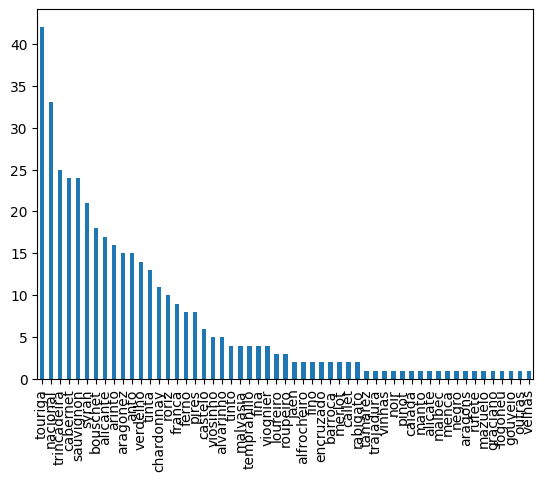

In [23]:
## a peak
data_df['variety'][0:400].value_counts().plot.bar()
#data_df['variety'].value_counts().plot.bar()

In [24]:
nan_value = float("NaN")
data_df.replace("", nan_value, inplace=True)
data_df.replace("None", nan_value, inplace=True)
data_df.dropna(subset=['variety'], inplace=True)
data_df.dropna(inplace=True)
#data_df.drop_duplicates(inplace=True)

In [25]:
data_df.reset_index(inplace=True)
data_df.drop(columns=['index'], inplace=True)

In [26]:
data_df.shape

(10569, 2)

In [27]:
documents = data_df.processed_text.to_list()
string_labels = data_df.variety.to_list()

le = preprocessing.LabelEncoder()
le.fit(data_df.variety)
data_df['cat_variety'] = le.transform(data_df.variety)

labels = data_df.cat_variety.to_list()

In [28]:
data_df.tail()

,variety,processed_text,cat_variety
10564,nacional,"[rubi, intensa, muito, concentrada, centro, la...",144
10565,touriga,"[rubi, intensa, muito, concentrada, centro, la...",204
10566,franca,"[rubi, intensa, muito, concentrada, centro, la...",78
10567,cabernet,"[rubi, intensa, muito, concentrada, centro, la...",35
10568,sauvignon,"[rubi, intensa, muito, concentrada, centro, la...",181


In [29]:
#type(data_df.iloc[10907].processed_text)

In [30]:
type(data_df.iloc[0].processed_text)

list

In [31]:
train_texts, valid_texts, train_labels, valid_labels = train_test_split(documents, labels, test_size=0.33)
target_names = varieties

In [32]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`

#train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
#valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, is_split_into_words=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, is_split_into_words=True)

In [33]:
class WineGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = WineGroupsDataset(train_encodings, train_labels)
valid_dataset = WineGroupsDataset(valid_encodings, valid_labels)

In [34]:
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names))#.to("cuda")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [35]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [36]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    save_steps=400,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [37]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
%%time

# train the model

trainer.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7081
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2658
Trainer is attempting to log a value of "{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6', 7: 'LABEL_7', 8: 'LABEL_8', 9: 'LABEL_9', 10: 'LABEL_10', 11: 'LABEL_11', 12: 'LABEL_12', 13: 'LABEL_13', 14: 'LABEL_14', 15: 'LABEL_15', 16: 'LABEL_16', 17: 'LABEL_17', 18: 'LABEL_18', 19: 'LABEL_19', 20: 'LABEL_20', 21: 'LABEL_21', 22: 'LABEL_22', 23: 'LABEL_2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss


In [ ]:
%%time
trainer.evaluate()

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "wine-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {v: k for v, k in enumerate(data_df.variety)}
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

In [ ]:
input1a = """I would like a type of wine that really wows. something perhaps to drink beside my best girlfriends on the beach somewhere. something that's new and exciting."""

In [ ]:
get_prediction(input1a, convert_to_label=True)

In [ ]:
input1b = """Eu gostaria de um tipo de vinho que realmente impressionasse. algo talvez para beber ao lado de minhas melhores amigas na praia em algum lugar. algo que é novo e excitante.""" 

In [ ]:
get_prediction(input1b, convert_to_label=True)

In [ ]:
input2a = """
i want a red to go with my salmon. I like my salmon cooked medium and I like white wines normally but I hear reds are full of antioxidents.
"""

In [ ]:
get_prediction(input2a, convert_to_label=True)

In [ ]:
input2b = """
eu quero um vermelho para ir com o meu salmão. Eu gosto do meu salmão médio e gosto de vinhos brancos normalmente, mas ouvi dizer que os tintos são cheios de antioxidantes.
"""

In [ ]:
get_prediction(input2b, convert_to_label=True)

In [ ]:
input3a = """
tickles the nose
"""

In [ ]:
get_prediction(input3a, convert_to_label=True)

In [ ]:
input3b = """
faz cócegas no nariz
"""

In [ ]:
get_prediction(input3b, convert_to_label=True)

In [ ]:
input4a = """
I want the driest white wine available. the most dry you can think of. bone-dry.
"""

In [ ]:
get_prediction(input4a, convert_to_label=True)

In [ ]:
input4b = """
Quero o vinho branco mais seco disponível. o mais seco que você pode pensar. Osso seco.
"""

In [ ]:
get_prediction(input4b, convert_to_label=True)

In [ ]:
input5a = """
I want a red. no wait I want a white. I think I want rose. on second thought, give me a bourbon. no, no. my favorite wine is a white. I'll do a white?
"""

In [ ]:
get_prediction(input5a, convert_to_label=True)

In [ ]:
input5a = """
Eu quero um vermelho. não espere, eu quero um branco. Acho que quero rosa. pensando bem, me dê um bourbon. não não. meu vinho favorito é um branco. Eu vou fazer um branco?
"""

In [ ]:
get_prediction(input5a, convert_to_label=True)